In [33]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim = 0)
            var = ((X -mean) ** 2).mean(dim = 0)
        else:
            # 卷积层的情况，计算通道维上的均值和方差
            # 保持X的形状后面做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # 'num_features': 全连接层的输出数量或卷积层的输出通道数
    # 'num_dims': 2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为1和0
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果 'X' 不在内存上，将'moving_mean'&'moving_var'复制到’X‘所在显存
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的'moving_mean'和’moving_var'
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

In [27]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
nn.MaxPool2d(kernel_size=2, stride=2), nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(), nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(), nn.Linear(84, 10))

In [35]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [38]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
nn.MaxPool2d(kernel_size=2, stride=2), nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(), nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(), nn.Linear(84, 10))

loss 0.248, train acc 0.909, test acc 0.841
38093.7 examples/sec on cuda:0


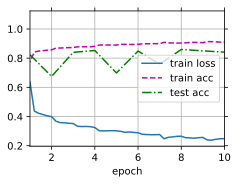

In [39]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())